In [170]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sktime.datasets import load_arrow_head, load_basic_motions
from sktime.transformations.panel.tsfresh import TSFreshRelevantFeatureExtractor
from sklearn.ensemble import RandomForestRegressor
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split
import sktime
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ExpandingWindowSplitter,
)
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.model_evaluation import evaluate
from sklearn.neural_network import MLPRegressor

In [135]:
statsmodels.__version__

'0.13.2'

In [136]:
df = pd.read_excel(r'C:\Users\kosta\Documents\PhD related\Python\Feature forecasting\All metals.xlsx',parse_dates = ['DATE'],index_col='DATE')

In [137]:
y = df['COPPER'].to_frame()

In [138]:
y 

,COPPER
DATE,
1990-01-01,2366.64
1990-02-01,2360.16
1990-03-01,2625.61
1990-04-01,2686.15
1990-05-01,2741.95
...,...
2022-05-01,9377.15
2022-06-01,9024.46
2022-07-01,7544.81


In [139]:
y.index = pd.PeriodIndex(pd.date_range(start=y.index[0],end='2022-09-30', freq = 'M'))
y.index

PeriodIndex(['1990-01', '1990-02', '1990-03', '1990-04', '1990-05', '1990-06',
             '1990-07', '1990-08', '1990-09', '1990-10',
             ...
             '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
             '2022-06', '2022-07', '2022-08', '2022-09'],
            dtype='period[M]', length=393)

In [140]:

trans1 = LogTransformer()
y_log = trans1.fit_transform(y)
trans = Differencer()


In [141]:
y = trans.fit_transform(y_log)

<AxesSubplot:>

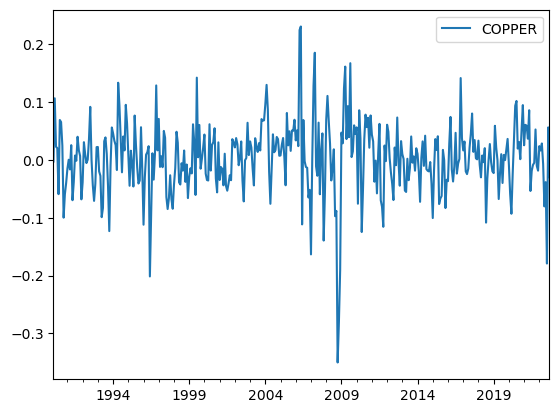

In [142]:
y.plot()

In [176]:
y_train, y_test = temporal_train_test_split(y)

regressor = make_pipeline(
    TSFreshRelevantFeatureExtractor(show_warnings=False, disable_progressbar=True),
    RandomForestRegressor(),
)
forecaster = make_reduction(
    regressor, scitype="time-series-regressor", window_length=12
)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

In [177]:
y_pred.index

PeriodIndex(['2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01',
             '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07',
             '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01',
             '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07',
             '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01',
             '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07',
             '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01',
             '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
             '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01',
             '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
             '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
             '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
             '2020-08', '2020-09', '2020-10', '2020-

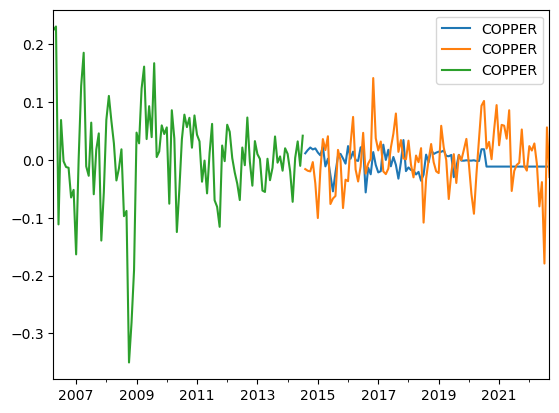

In [178]:
fig, ax = plt.subplots()
y_pred.plot(ax=ax)
y_test.plot(ax=ax)
y_train.iloc[-100:].plot(ax=ax)
plt.show()

In [134]:
y

,COPPER
1990-01,2366.64
1990-02,2360.16
1990-03,2625.61
1990-04,2686.15
1990-05,2741.95
...,...
2022-05,9377.15
2022-06,9024.46
2022-07,7544.81
2022-08,7981.84


In [174]:
param_grid = {"estimator__randomforestregressor__n_estimators":[50,100,150,200],
              "window_length": np.arange(20,25)}

cv = ExpandingWindowSplitter(initial_window=int(len(y_train) * 0.8), fh=np.arange(1,4))
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid,scoring= MeanSquaredError(square_root=True),
verbose=3)

In [175]:
gscv.get_params().keys()

dict_keys(['backend', 'cv__fh', 'cv__initial_window', 'cv__start_with_window', 'cv__step_length', 'cv', 'error_score', 'forecaster__estimator__memory', 'forecaster__estimator__steps', 'forecaster__estimator__verbose', 'forecaster__estimator__tsfreshrelevantfeatureextractor', 'forecaster__estimator__randomforestregressor', 'forecaster__estimator__tsfreshrelevantfeatureextractor__chunksize', 'forecaster__estimator__tsfreshrelevantfeatureextractor__default_fc_parameters', 'forecaster__estimator__tsfreshrelevantfeatureextractor__disable_progressbar', 'forecaster__estimator__tsfreshrelevantfeatureextractor__distributor', 'forecaster__estimator__tsfreshrelevantfeatureextractor__fdr_level', 'forecaster__estimator__tsfreshrelevantfeatureextractor__hypotheses_independent', 'forecaster__estimator__tsfreshrelevantfeatureextractor__impute_function', 'forecaster__estimator__tsfreshrelevantfeatureextractor__kind_to_fc_parameters', 'forecaster__estimator__tsfreshrelevantfeatureextractor__ml_task', 'f

In [169]:
gscv.fit(y_train)

Fitting 57 folds for each of 20 candidates, totalling 1140 fits


KeyboardInterrupt: 

In [ ]:
forecaster = gscv.best_forecaster_
forecaster

In [179]:
evalu = evaluate(forecaster,cv=cv,y=y_train,return_data=True,scoring=MeanSquaredError(square_root=True))
print(f"Mean MSE {evalu['test_MeanSquaredError'].mean()}, +- {evalu['test_MeanSquaredError'].std()}")

C:\Users\kosta\anaconda3\lib\site-packages\sktime\forecasting\model_evaluation\_functions.py:182: FitFailedWarning: 
                Fitting of forecaster failed, you can set error_score='raise' to see
                the exception message. Fit failed for len(y_train)=244.
                The score will be set to nan.
                Failed forecaster: RecursiveTimeSeriesRegressionForecaster(estimator=Pipeline(steps=[('tsfreshrelevantfeatureextractor',
                                                                   TSFreshRelevantFeatureExtractor(disable_progressbar=True,
                                                                                                   show_warnings=False)),
                                                                  ('randomforestregressor',
                                                                   RandomForestRegressor())]),
                                        window_length=12).
                
  
C:\Users\kosta\anaconda3\lib\s

Mean MSE 0.05230428080065918, +- 0.022742685763745378


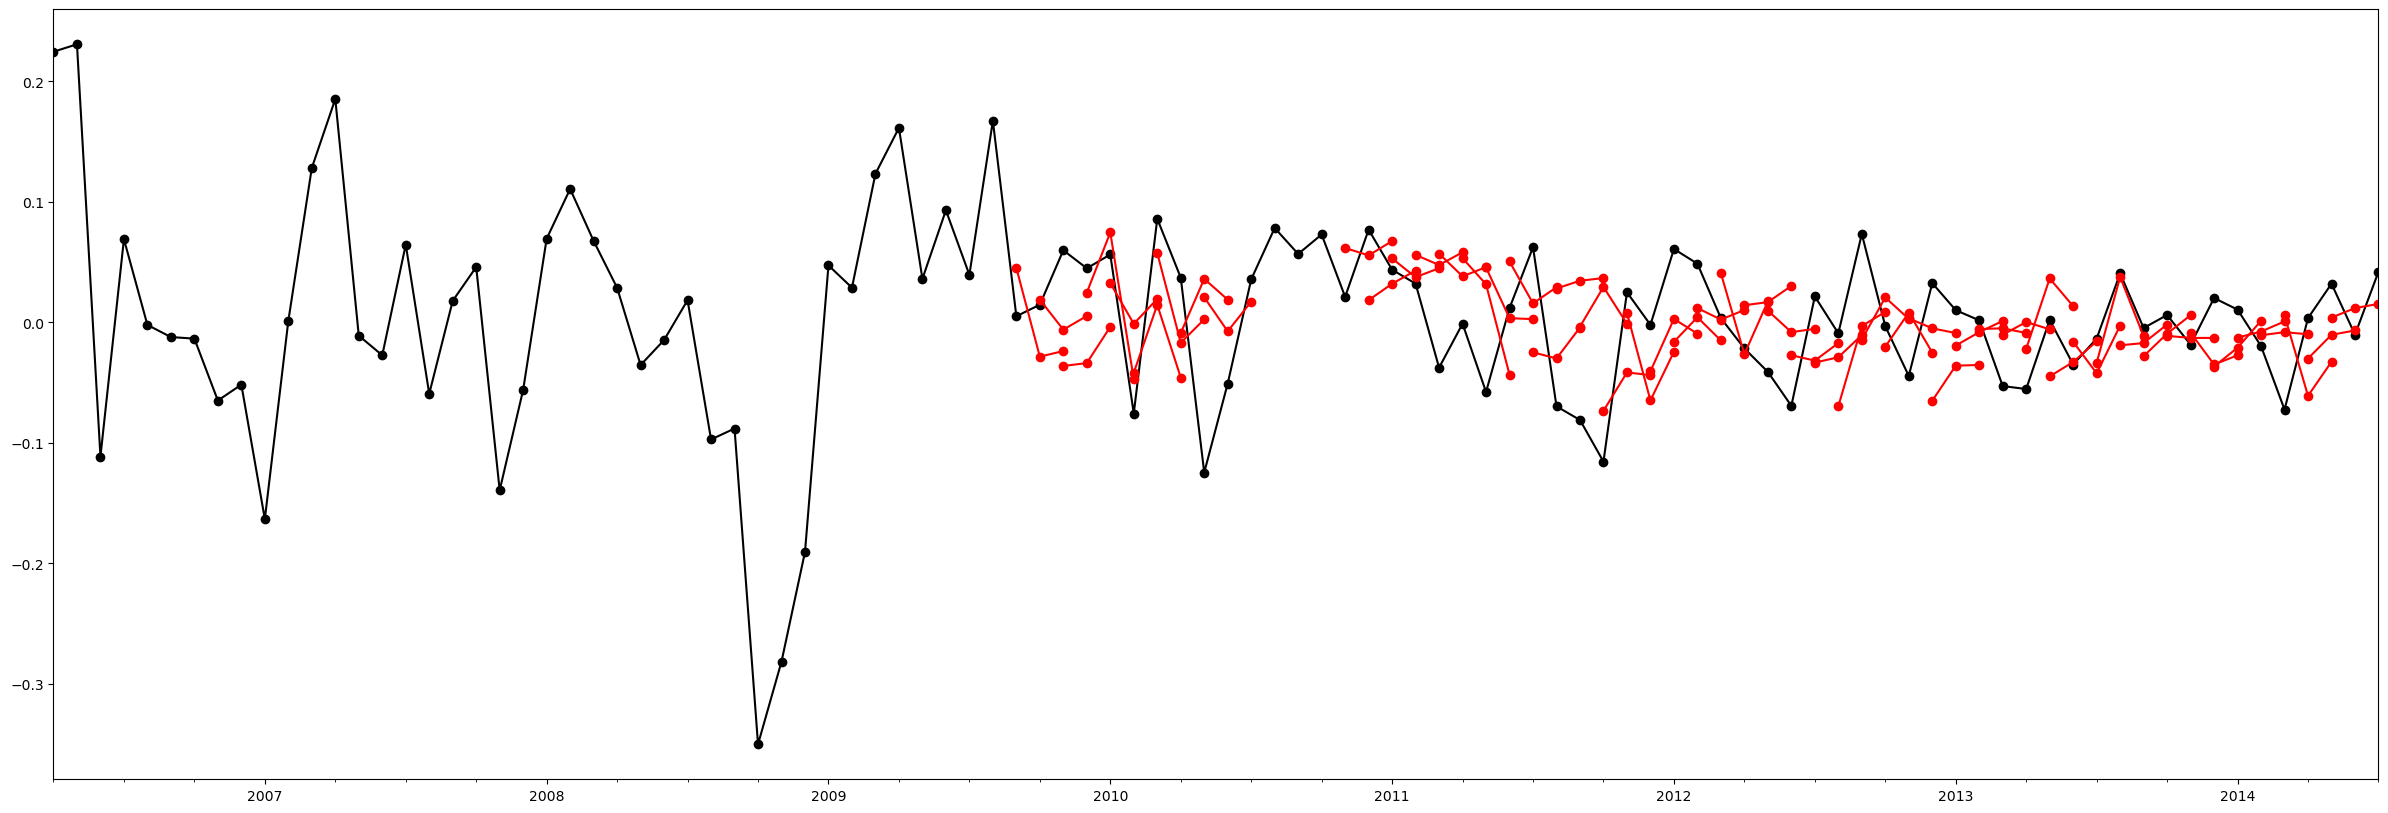

In [183]:
ax = y_train.iloc[-100:].plot(marker='o',figsize=(30,10),c='black')
for i in range(len(evalu)):
    try:
        evalu['y_pred'].iloc[i].plot(ax=ax,marker='o',c='red',figsize=(30,10))
        ax.get_legend().remove()
    except:
        pass

In [181]:
for i in range(len(evalu)):
    print(evalu['y_pred'].iloc[i])

           COPPER
2009-09  0.045163
2009-10 -0.028462
2009-11 -0.023778
           COPPER
2009-10  0.018821
2009-11 -0.006053
2009-12  0.005265
           COPPER
2009-11 -0.036200
2009-12 -0.033777
2010-01 -0.003740
           COPPER
2009-12  0.024653
2010-01  0.074622
2010-02 -0.047264
           COPPER
2010-01  0.032609
2010-02 -0.001199
2010-03  0.019488
           COPPER
2010-02 -0.041776
2010-03  0.014553
2010-04 -0.045767
           COPPER
2010-03  0.057555
2010-04 -0.016921
2010-05  0.002496
           COPPER
2010-04 -0.008883
2010-05  0.036096
2010-06  0.018830
           COPPER
2010-05  0.020812
2010-06 -0.007428
2010-07  0.017268
nan
nan
nan
nan
nan
           COPPER
2010-11  0.061728
2010-12  0.055555
2011-01  0.067467
           COPPER
2010-12  0.018409
2011-01  0.032045
2011-02  0.042921
           COPPER
2011-01  0.053000
2011-02  0.037496
2011-03  0.044940
           COPPER
2011-02  0.055975
2011-03  0.047629
2011-04  0.058112
           COPPER
2011-03  0.057020
2011-04 